In [281]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from datetime import datetime, timedelta
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint, Point
from sklearn.metrics.pairwise import haversine_distances

## Datesets

1. SF Cabs dataset from CRAWDAD: https://ieee-dataport.org/open-access/crawdad-epflmobility
2. intersection counts: https://www.sfmta.com/reports/sfmta-traffic-count-data
3. map of traffic lights: https://data.sfgov.org/Transportation/Map-of-Traffic-Signals
4. info on cellular towers: https://www.city-data.com/towers/cell-San-Francisco-California.html
5. source for traffic light clustering: https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/

In [145]:
# parse sf cabs and store in dataframes
files = [f'../datasets/cabspottingdata/{file}' for file in os.listdir('../datasets/cabspottingdata/')]

start=0
end=100
cars = []
for f in tqdm(files):
    if not f.endswith('.txt'):
        continue 
    if f.endswith("_cabs.txt"):
        continue
    df = pd.read_csv(f, header=None, sep=' ')
    df['dt'] = pd.to_datetime(df[3],unit='s')

    cars.append(df)
#     ax.plot(df[0][start:end],df[1][start:end])#, s=1)
    


100%|███████████████████████████████████████████████████████████| 538/538 [00:03<00:00, 159.84it/s]


In [172]:

# find earliest starting car
mints = np.inf
minc = None
for car in cars:
    if mints > car[3].iloc[-1]:
        minc = car
        mints = car[3].iloc[-1]


In [178]:
# calculate 1hr from earliest timestamp
lim_dt = pd.to_datetime(mints, unit='s')+timedelta(hours=1)

In [335]:
# filter all cars moving within the hour calculated above
filtered_cars = []
for car in cars:
    if car['dt'].iloc[-1] > lim_dt:
        continue
    tinydf = car[car['dt'] < lim_dt][::-1]
    tinydf = tinydf.reset_index()
    tinydf.drop(columns=['index'])
    if not tinydf.empty:
        filtered_cars.append(tinydf)

In [336]:
filtered_cars[0]

,index,0,1,2,3,dt
0,11517,37.77698,-122.42205,1,1211018446,2008-05-17 10:00:46
1,11516,37.77576,-122.42410,1,1211018507,2008-05-17 10:01:47
2,11515,37.77473,-122.43198,1,1211018567,2008-05-17 10:02:47
3,11514,37.77347,-122.44246,1,1211018640,2008-05-17 10:04:00
4,11513,37.77221,-122.45185,1,1211018688,2008-05-17 10:04:48
...,...,...,...,...,...,...
56,11461,37.78065,-122.39072,0,1211021592,2008-05-17 10:53:12
57,11460,37.77831,-122.39187,0,1211021653,2008-05-17 10:54:13
58,11459,37.77643,-122.39434,0,1211021714,2008-05-17 10:55:14
59,11458,37.76800,-122.39661,0,1211021807,2008-05-17 10:56:47


In [217]:
def conv_shape(x):
    tokens = x.split(' ')
    lat = float(tokens[1][1:])
    lon = float(tokens[2][:-1])
    return lat, lon 

In [277]:
# cluster the traffic lights and obtain centroids
df = pd.read_csv('../datasets/Traffic_Signals_20231211.csv')
df['x'],df['y'] = zip(*df['shape'].apply(conv_shape))
coords = df[['x','y']].values


kms_per_radian = 6371.0088
# controls the number of clusters
eps = 0.5 / kms_per_radian
ms=1

db = DBSCAN(eps=eps, min_samples=ms, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

print('Number of clusters: {}'.format(num_clusters))

def get_centermost_point(cluster):
    return (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)

centroids = clusters.map(get_centermost_point)
cx,cy = zip(*centroids)
centroids_np = np.vstack((cx,cy))
np.save('../datasets/12-nodes.npy',centroids_np) 

Number of clusters: 12


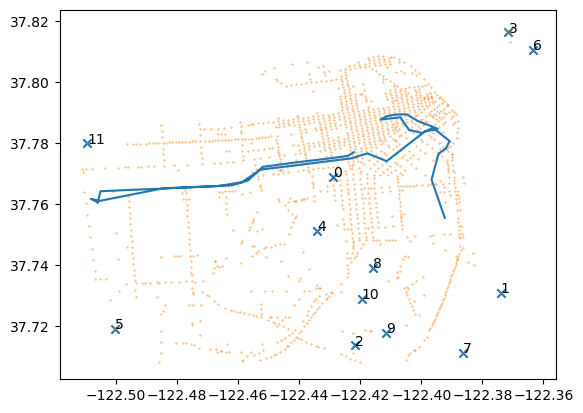

In [308]:
# plot for visualizing edge nodeks and route
fig, ax = plt.subplots()
for car in filtered_cars[:1]:
    ax.plot(car[1],car[0]) 
ax.scatter(cx, cy, marker='x')
ax.scatter(df['x'],df['y'],s=0.1)
for i,x in enumerate(cx):
    y = cy[i]
    ax.annotate(str(i),(x,y))

In [311]:
# get radian centroids for haversine distances
x,y = zip(*centroids)
centroids_np = np.radians(np.vstack((x,y)).T)

In [354]:
# assigns proximal edge node to every line in the route
for i,car in enumerate(filtered_cars):
    route = np.radians(car[[1,0]].values)
    dists = haversine_distances(centroids_np,route)               
    car['node'] = dists.T.argmin(axis=1)
    car['ts'] = car[3]-car[3].at[0]
    car.to_csv(f'../datasets/routes/route{i}.csv', index=False)


In [352]:
car

,index,0,1,2,3,dt,node
0,23193,37.76568,-122.47330,1,1211018432,2008-05-17 10:00:32,5
1,23192,37.76547,-122.47714,1,1211018493,2008-05-17 10:01:33,11
2,23191,37.76490,-122.48473,1,1211018558,2008-05-17 10:02:38,11
3,23190,37.76234,-122.48457,1,1211018618,2008-05-17 10:03:38,11
4,23189,37.76231,-122.48462,1,1211018673,2008-05-17 10:04:33,11
5,23188,37.76225,-122.48458,1,1211018724,2008-05-17 10:05:24,11
6,23187,37.76248,-122.48460,0,1211018744,2008-05-17 10:05:44,11
7,23186,37.76510,-122.48388,0,1211018804,2008-05-17 10:06:44,11
8,23185,37.76532,-122.47898,0,1211018864,2008-05-17 10:07:44,11
9,23184,37.76549,-122.47494,0,1211018925,2008-05-17 10:08:45,11
